In [1]:
import sys
from pathlib import Path

import numpy as np
from tqdm.auto import tqdm
import pandas as pd
current_dir = Path.cwd()
parent_dir = str(current_dir.parent.parent)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from src.constant import DATA_DIR, MAIN_DIR, DATABASE_DIR
from src.database.db import DB
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file

PHASE1_DIR = MAIN_DIR / "archive" / "phase1" 
RAW_DIR = PHASE1_DIR / "raw"
PROCESSED_DIR = PHASE1_DIR / "processed"

In [2]:
query = """
select
    solver_id,
    filepath,
    cost
from results
join instances on results.instance_id = instances.id
"""

explosion = DB(RAW_DIR / "run-phase1-dataset2-993370.db").query2df(query)
explosion2 = DB(RAW_DIR / "run-phase1-dataset-995185.db").query2df(query)
expansion = DB(RAW_DIR / "run-phase1-dataset2-993505.db").query2df(query)
expansion2 = DB(RAW_DIR / "run-phase1-dataset-995184.db").query2df(query)

cluster_compression = DB(RAW_DIR / "run-phase1-dataset-993244.db").query2df(query)
cluster_compression = cluster_compression.loc[cluster_compression["filepath"].str.contains("cluster_netgen|compression")]
cluster2 = DB(RAW_DIR / "run-phase1-dataset-995182.db").query2df(query)
cluster2 = cluster2.loc[~cluster2["filepath"].str.contains("019.tsp")]
cluster3 = DB(RAW_DIR / "run-phase1-dataset-997329.db").query2df(query)
compression2 = DB(RAW_DIR / "run-phase1-dataset-995187.db").query2df(query)

grid1 = DB(RAW_DIR / "run-phase1-dataset2-993371.db").query2df(query)
grid1 = grid1.loc[~grid1["filepath"].str.contains("014.tsp")]
grid2 = DB(RAW_DIR / "run-phase1-dataset2-994508.db").query2df(query)
grid3 = DB(RAW_DIR / "run-phase1-dataset-995186.db").query2df(query)

df = (
    pd.concat([
        explosion,
        explosion2,
        expansion,
        expansion2,
        cluster_compression,
        cluster2,
        cluster3,
        compression2,
        grid1,
        grid2,
        grid3,
    ])
    .rename(columns={"filepath": "instance_id"})
    .sort_values("instance_id")
    .reset_index(drop=True)
)
df["cost"] = np.where(df["cost"] == 3000.0, df["cost"] / 10, df["cost"])
df["generator"] = df["instance_id"].apply(lambda x: x.split("/")[-2])
df.loc[:, ["solver_id", "instance_id", "generator", "cost"]].to_parquet(PROCESSED_DIR / "evaluations.parquet")

In [28]:
solvers_df = pd.concat([
    DB(RAW_DIR / "run-phase1-dataset2-993371.db").get_solvers(),
    DB(RAW_DIR / "run-phase1-dataset-995182.db").get_solvers(),
]).reset_index(drop=True)
solvers_df.to_parquet(PROCESSED_DIR / "solvers.parquet")

In [29]:
df["solver_id"].nunique(), df["instance_id"].nunique()

(1000, 100)

In [19]:
df.groupby("generator")["cost"].describe()

,count,mean,std,min,25%,50%,75%,max
generator,,,,,,,,
cluster_netgen,20000.0,94.599668,126.257357,0.0,0.91,11.700,267.0575,300.0
compression,20000.0,80.732920,120.133439,0.0,0.68,6.935,134.4050,300.0
expansion,20000.0,68.505207,113.706131,0.0,0.27,3.560,70.7925,300.0
explosion,20000.0,79.087429,119.501065,0.0,0.63,6.055,126.1475,300.0
grid,20000.0,68.784856,114.837667,0.0,0.27,2.720,72.0325,300.0


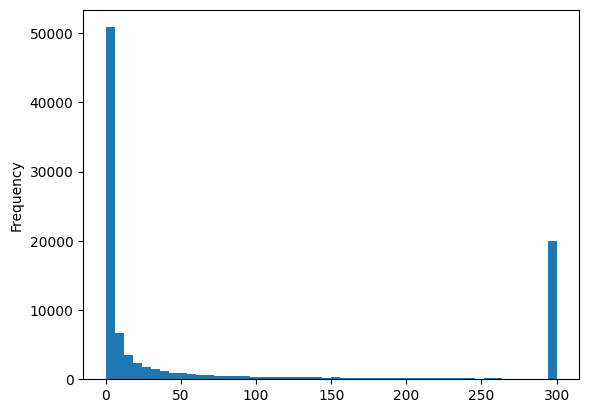

In [20]:
df["cost"].plot.hist(bins=50);

In [21]:
(df["cost"] == 300).value_counts(normalize=True)

False    0.80111
True     0.19889
Name: cost, dtype: float64

In [22]:
df.loc[df["cost"] < 300, "solver_id"].nunique()

973

In [23]:
df.groupby("solver_id")["cost"].max().loc[lambda x: x < 300]

solver_id
1002471113494523905    179.90
1020543843281966762     16.39
1021573058298010931    128.50
1028542701154549227     75.34
1043101103933922134     22.66
                        ...  
962840036408618598     235.86
962883005813177462       9.24
970611356426903166      71.48
973335114157418680     112.45
991708024745890116     259.29
Name: cost, Length: 334, dtype: float64

In [24]:
df.assign(is_timeout=lambda x: x["cost"] == 300).groupby("solver_id")["is_timeout"].mean().sort_values(ascending=True).loc[lambda x: x < 0.8]

solver_id
2015558950952358772    0.00
1733104218805818797    0.00
1730848150240827803    0.00
1725342735224443171    0.00
1721638763408659811    0.00
                       ... 
1703170494775071241    0.76
2266014232418182719    0.76
1480426067213915705    0.78
1236493675070612438    0.79
990737851297008821     0.79
Name: is_timeout, Length: 911, dtype: float64

In [ ]:
all_instances = TSP_from_index_file(
    filepath=DATA_DIR / "TSP" / "TRAIN" / "index.json",
    max_cost=3000.0,
    max_time=300.0,
)

instances = InstanceList()
for i in [0, 200, 400, 600, 800]:
    instances.extend(all_instances[i : i + 20])

for instance in tqdm(instances):
    try:
        instance.calculate_features()
        instance.to_db()
    except Exception as e:
        print(instance, e)

In [ ]:
instances_df = (
    DB(DATABASE_DIR / "test-2025_03_23_19_00_48.db").get_instances()
    .drop(columns=["id", "optimum", "max_cost", "max_time"])
    .rename(columns={"filepath": "id"})
    .to_parquet(PROCESSED_DIR / "instances.parquet")
)

instances_df.to_parquet(PROCESSED_DIR / "instances.parquet")